# Discrimination between $t\bar{t}$ in the all-jet final state and QCD background using the scaled dot product attention

In [1]:
%matplotlib inline
import sys
from collections import namedtuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import tensorflow.compat.v1 as tf
import tensorflow.keras.backend as K
tf.enable_eager_execution()
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from uncertainty import compute_variation_ratio
from uncertainty import compute_predictive_entropy
from uncertainty import compute_mutual_information

In [2]:
print(sys.version)
print(tf.version.VERSION)
print(tfp.__version__)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
1.14.0
0.7.0


In [3]:
seed = 0
random_state = 0
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

# Data Loading and Preprocessing

In [4]:
npz_file = np.load('../data/ttbar-all-jets_vs_QCD.npz')

In [5]:
x_tt = npz_file['tt']
x_qcd = npz_file['qcd']
feature_name = npz_file['feature_name']

In [6]:
y_qcd = np.zeros(len(x_qcd), dtype=np.int64)
y_tt = np.ones(len(x_tt), dtype=np.int64)

x = np.concatenate([x_qcd, x_tt])
y = np.concatenate([y_qcd, y_tt])

num_examples = len(x)

# reshape for the minmax scaling
x = x.reshape(num_examples, -1)

x, y = shuffle(x, y)
y = tfk.utils.to_categorical(y).astype(np.int64)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2 / 0.8)

In [8]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_valid = minmax.transform(x_valid)
x_test = minmax.transform(x_test)

x_train = x_train.reshape(-1, 6, 9)
x_valid = x_valid.reshape(-1, 6, 9)
x_test = x_test.reshape(-1, 6, 9)

In [9]:
Datasets = namedtuple('Datasets', ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test'])
datasets = Datasets(x_train, y_train, x_valid, y_valid, x_test, y_test)

In [10]:
def plot_learning_curve(history, title=None):
    kwargs = {'ls': '--', 'marker': 'o'}

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    axarr[0].plot(history.history['loss'], label='Training', **kwargs)
    axarr[0].plot(history.history['val_loss'], label="Validation", **kwargs)
    axarr[0].set_title("Loss")
    axarr[0].set_xlabel('Epoch')
    axarr[0].legend()

    axarr[1].plot(history.history['acc'], label='Training', **kwargs)
    axarr[1].plot(history.history['val_acc'], label="Validation", **kwargs)
    axarr[1].set_title("Accuracy")
    axarr[1].set_xlabel('Epoch')
    axarr[1].legend()
    
    if title is not None:
        fig.suptitle(title)

def run_experiment(model,
                   loss,
                   datasets,
                   log_name,
                   title=None,
                   learning_rate=0.01,
                   epochs=100,
                   batch_size=256):
    
    model.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=loss,
        metrics=['accuracy'])

    history = model.fit(
        datasets.x_train,
        datasets.y_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(datasets.x_valid, datasets.y_valid),
        verbose=0,
        callbacks=[tf.keras.callbacks.TensorBoard(log_name)])


    loss, acc = model.evaluate(datasets.x_test, datasets.y_test, verbose=False)
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")

    plot_learning_curve(history, title)
    return acc

# Create probabilistic model
*  [Probabilistic Layer Regression](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
*  [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical)

In [11]:
kl_weight = 1 / len(x_train)
print(kl_weight)

2.380952380952381e-05


In [12]:
def negative_log_likelihood(y_true, y_pred_rv):
    return -y_pred_rv.log_prob(y_true)

In [13]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
  ])

In [14]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
    ])

In [15]:
def evaluate(model, x, y, num_monte_carlo=100):
    samples = tf.stack([model(x).probs for _ in range(num_monte_carlo)]).numpy()[:, :, 1]
    y_hat = samples.mean(axis=0)
    y = y[:, 1]
    accuracy = ((y_hat > 0.5).astype(int) == y).mean()
    print(f"Accuracy: {accuracy}")
    return accuracy

# Variational
I made it by referring to [Transformer model for language understanding](https://www.tensorflow.org/beta/tutorials/text/transformer#multi-head_attention)
I remove masking for simplicity

In [16]:
class MultiHeadAttentionVariational(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, kl_weight):
        super(MultiHeadAttentionVariational, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tfpl.DenseVariational(
            units=d_model,
            make_posterior_fn=posterior_mean_field,
            make_prior_fn=prior_trainable,
            kl_weight=kl_weight)
        
        self.wk = tfpl.DenseVariational(
            units=d_model,
            make_posterior_fn=posterior_mean_field,
            make_prior_fn=prior_trainable,
            kl_weight=kl_weight)
            
        self.wv = tfpl.DenseVariational(
            units=d_model,
            make_posterior_fn=posterior_mean_field,
            make_prior_fn=prior_trainable,
            kl_weight=kl_weight)

        self.dense = tfpl.DenseVariational(
            units=d_model,
            make_posterior_fn=posterior_mean_field,
            make_prior_fn=prior_trainable,
            kl_weight=kl_weight)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, tensor):
        batch_size = tf.shape(tensor)[0]

        q = self.wq(tensor)  # (batch_size, seq_len, d_model)
        k = self.wk(tensor)  # (batch_size, seq_len, d_model)
        v = self.wv(tensor)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        # scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v)
        
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

        # scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

        scaled_attention = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
        
        
        

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output# , attention_weights

In [17]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    MultiHeadAttentionVariational(16, 2, kl_weight),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(y_train.shape[-1]) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfkl.Lambda(lambda tensor: K.sum(tensor, axis=1), output_shape=(None, 16)),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(y_train.shape[-1]) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(y_train.shape[-1]),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
multi_head_attention_variati (None, None, 16)          2256      
_________________________________________________________________
dense_variational_4 (DenseVa (None, None, 1)           51        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
_________________________________________________________________
dense_variational_5 (DenseVa (None, 1)                 6         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
one_hot_categorical (OneHotC ((None, 2), (None, 2))    0         
Total params: 2,313
Trainable params: 2,313
Non-trainable params: 0
______________________________________________________

Loss: 0.4802
Accuracy: 0.6986
Accuracy: 0.7832142857142858


0.7832142857142858

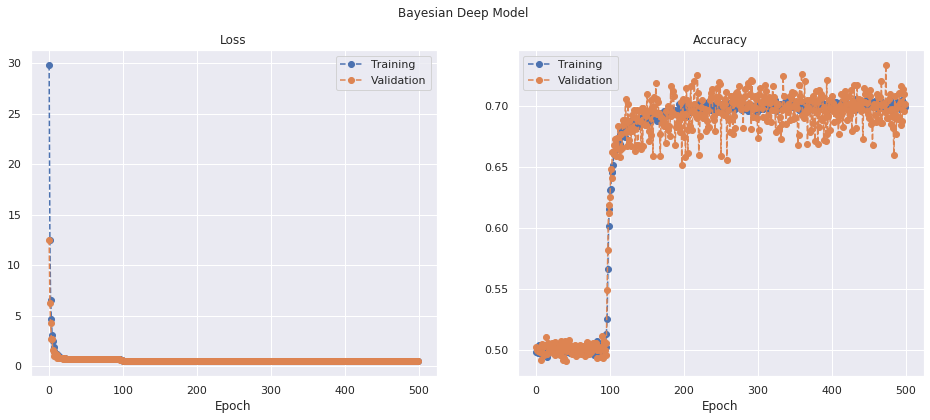

In [18]:
model.set_weights(initial_weights)

run_experiment(model,
               loss=negative_log_likelihood,
               datasets=datasets,
               log_name='logs-bayesian',
               title='Bayesian Deep Model',
               learning_rate=0.01,
               epochs=500)


evaluate(model, datasets.x_test, datasets.y_test)

# Performance metrics

In [19]:
num_monte_carlo = 100
prediction_samples = tf.stack([model(x_test).probs for _ in range(num_monte_carlo)]).numpy()

In [20]:
predictive_mean = prediction_samples[:, :, 1].mean(axis=0)
predictive_variance = prediction_samples[:, :, 1].var(axis=0)

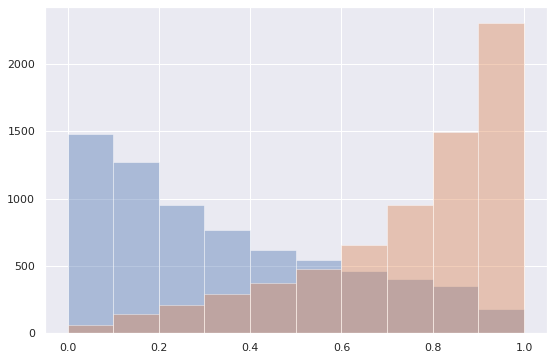

In [21]:
fig, ax = plt.subplots(figsize=(9, 6))

hist_kwargs = {
    'range': (0, 1),
    'bins': 10,
    #'density': True,
    'alpha': 0.4,
}

_ = ax.hist(predictive_mean[y_test[:, 1] == 0], **hist_kwargs)
_ = ax.hist(predictive_mean[y_test[:, 1] == 1], **hist_kwargs)

In [22]:
fpr, tpr, _ = metrics.roc_curve(y_true=y_test[:, 1], y_score=predictive_mean)
tnr = 1 - fpr
auc = metrics.auc(tpr, tnr)

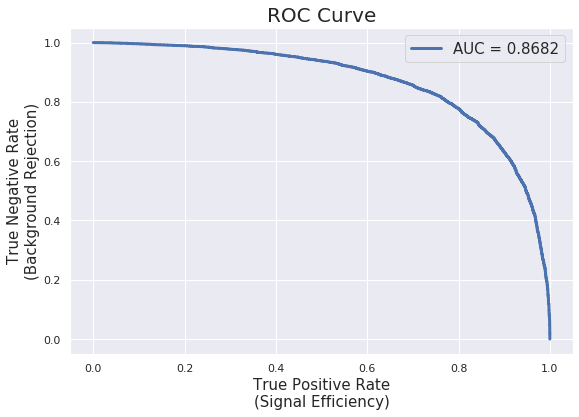

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))

label = 'AUC = {:.4f}'.format(auc)

_ = ax.plot(tpr, tnr, label=label, lw=3)

ax.legend(fontsize=15, loc='best')

_ = ax.set_title("ROC Curve", fontsize=20)

_ = ax.set_xlabel('True Positive Rate\n(Signal Efficiency)', fontdict={'size': 15})
_ = ax.set_ylabel('True Negative Rate\n(Background Rejection)', fontdict={'size': 15})

# Uncertainty

In [24]:
variation_ratio = compute_variation_ratio(prediction_samples)
predictive_entropy = compute_predictive_entropy(prediction_samples)
mutual_information = compute_mutual_information(prediction_samples)

In [25]:
def plot_uncertainty(mu, uncertainty, title=None, color='inferno'):
    if isinstance(color, str):
        color = sns.color_palette(color)
    
    
    is_zero = y_test[:, 1] == 0
    is_one = y_test[:, 1] == 1
    
    # fig, axarr = plt.subplots(ncols=2, figsize=(12, 6))
    
    # axarr[0].scatter(mu[is_zero], uncertainty[is_zero], s=5, alpha=0.1)
    # axarr[1].scatter(mu[is_one], uncertainty[is_one], s=5, alpha=0.1)
    
    # sns.kdeplot(mu[is_zero], uncertainty[is_zero], ax=axarr[0], cmap='Reds', cbar=True, shade=True, shade_lowest=False)
    # sns.kdeplot(mu[is_one], uncertainty[is_one], ax=axarr[1], cmap='Blues', cbar=True, shade=True, shade_lowest=False)
    sns.set_style('white')
    
    ax0 = sns.jointplot(x=mu[is_zero], y=uncertainty[is_zero],  kind="hex", color='lightcoral')
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
    cbar_ax = ax0.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
    plt.colorbar(cax=cbar_ax)
    
    
    ax1 = sns.jointplot(x=mu[is_one], y=uncertainty[is_one], kind="hex", color='cornflowerblue')
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
    cbar_ax = ax1.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
    plt.colorbar(cax=cbar_ax)


    if title is not None:
        fig.suptitle(title)

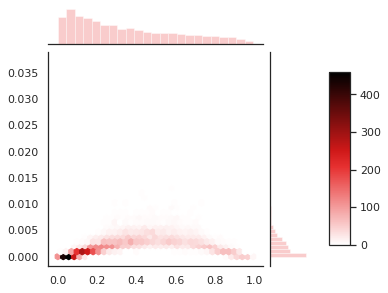

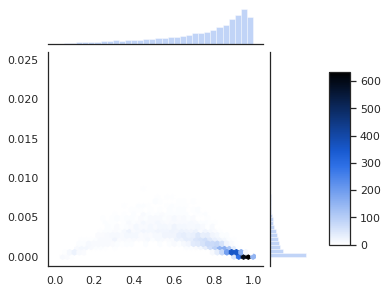

In [26]:
plot_uncertainty(predictive_mean, predictive_variance, title='Predictive Variance')

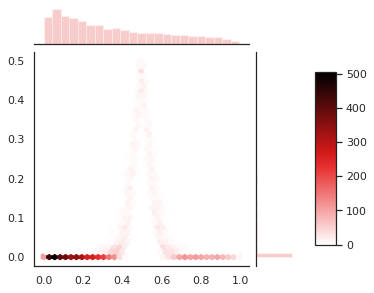

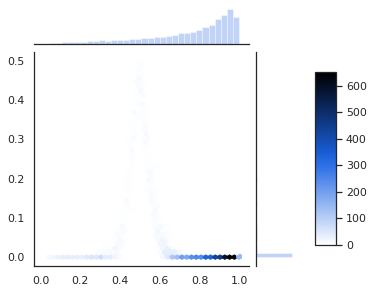

In [27]:
plot_uncertainty(predictive_mean, variation_ratio, title='Variation Ratio')

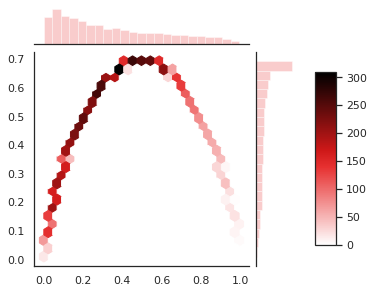

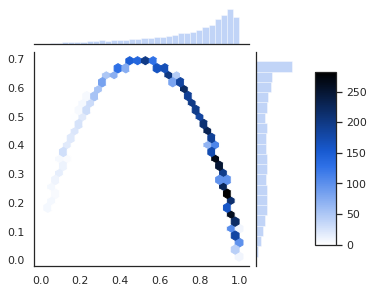

In [28]:
plot_uncertainty(predictive_mean, predictive_entropy, title="Predictive Entropy")

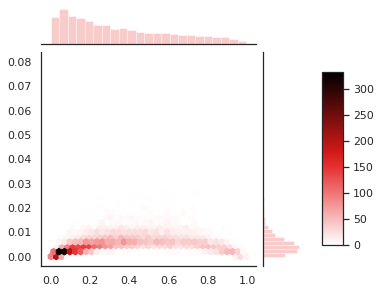

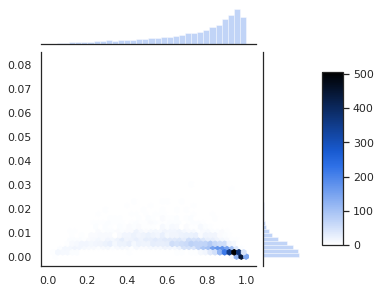

In [29]:
plot_uncertainty(predictive_mean, mutual_information, title="Mutual Information")

In [30]:
y_pred = predictive_mean > 0.5
y_true = y_test[..., 1]

In [31]:
def draw_uncertainty(y_true, y_pred,
                     uncertainty,
                     uncertainty_name,
                     title, log=False):
    
    is_sig = y_true == 1
    is_bkg = y_true == 0

    is_true_pos = np.logical_and(is_sig, y_pred == 1)
    is_false_neg = np.logical_and(is_sig, y_pred == 0)

    is_true_neg = np.logical_and(is_bkg, y_pred == 0)
    is_false_pos = np.logical_and(is_bkg, y_pred == 1)
    
    
    signal = [
        uncertainty[is_true_pos],
        uncertainty[is_false_neg]
    ]

    background = [
        uncertainty[is_true_neg],
        uncertainty[is_false_pos]
    ]

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    suptitle = fig.suptitle(title, fontsize="x-large")

    signal_hists, _, _ = axarr[0].hist(
        signal,
        label=["signal (Correct)", "signal (Incorrect)"],
        color=['skyblue', 'b'],
        stacked=True, bins=50, alpha=0.3)

    background_hists, _, _ = axarr[1].hist(
        background,
        label=["background (Correct)", "background (Incorrect)"],
        color=['lightcoral', 'r'],
        stacked=True, bins=50, alpha=0.5)

    max_value = max(each.max() for each in signal_hists + background_hists)
    y_max = 1.05 * max_value

    for ax in axarr:
        ax.grid()
        ax.legend(fontsize=15)
        ax.set_xlabel(uncertainty_name)
        if log:
            ax.set_yscale('log')

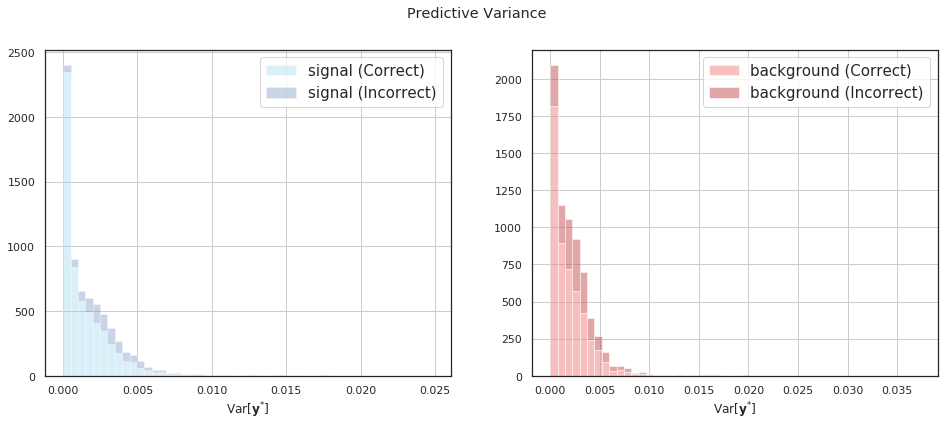

In [32]:
draw_uncertainty(y_true, y_pred, predictive_variance, r'Var$[ \mathbf{y}^{*}]$', 'Predictive Variance')

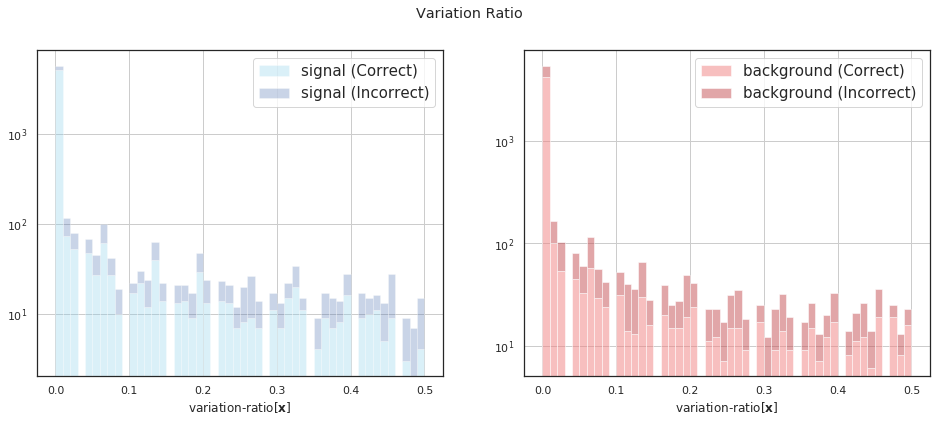

In [33]:
draw_uncertainty(y_true, y_pred, variation_ratio, r'variation-ratio[$\mathbf{x}$]', 'Variation Ratio', True)

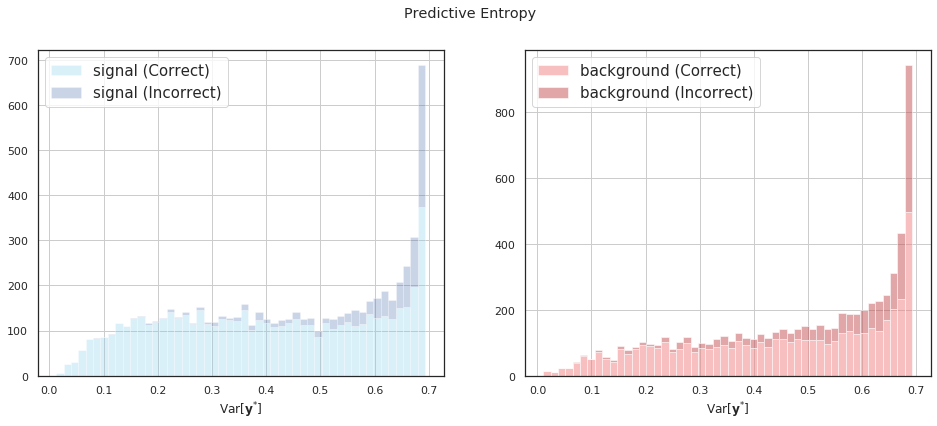

In [34]:
draw_uncertainty(y_true, y_pred, predictive_entropy, r'Var$[ \mathbf{y}^{*}]$', 'Predictive Entropy')

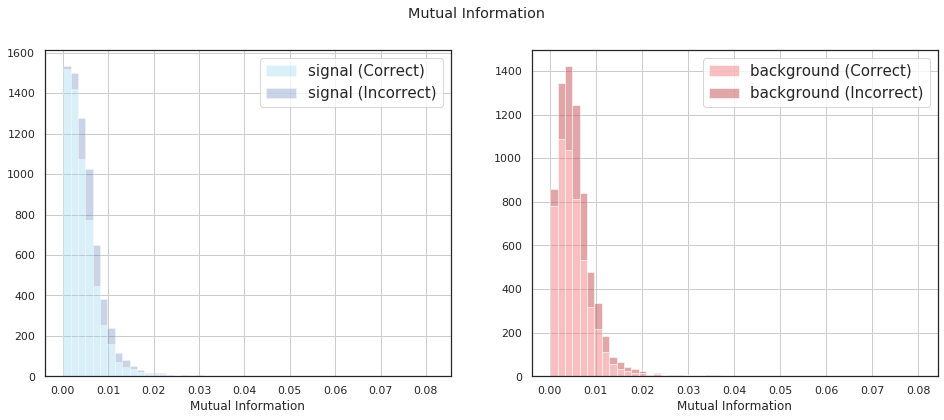

In [35]:
draw_uncertainty(y_true, y_pred, mutual_information, 'Mutual Information', 'Mutual Information')

# Signal Efficiency vs Significance

In [36]:
def draw_curve(y_true, y_pred,
               uncertainty,
               title):
    
    is_sig = y_true == 1
    is_bkg = y_true == 0

    is_true_pos = np.logical_and(is_sig, y_pred == 1)
    is_false_neg = np.logical_and(is_sig, y_pred == 0)

    is_true_neg = np.logical_and(is_bkg, y_pred == 0)
    is_false_pos = np.logical_and(is_bkg, y_pred == 1)
    
    
    signal_efficiency = []
    background_efficiency = []
    for cut in np.linspace(uncertainty.min(), uncertainty.max()):
        good = uncertainty < cut
        
        if sum(good) == 0:
            continue
        
        sig_eff = sum(is_true_pos[good]) / sum(is_sig)
        bkg_eff = sum(is_false_pos[good]) / sum(is_bkg)
        
        signal_efficiency.append(sig_eff)
        background_efficiency.append(bkg_eff)

    sig_eff = np.array(signal_efficiency)
    bkg_eff = np.array(background_efficiency)

    fig, ax = plt.subplots(figsize=(6, 4))
    suptitle = fig.suptitle(title, fontsize="x-large")

    # NOTE
    safe_idx = bkg_eff.nonzero()
    bkg_eff = bkg_eff[safe_idx]
    sig_eff = sig_eff[safe_idx]

    inv_sqrt_bkg_eff = 1 / np.sqrt(bkg_eff)
    line1 = ax.plot(sig_eff, inv_sqrt_bkg_eff,
                    marker="o", ls="--", color="mediumorchid",
                    label=r"$1 / \sqrt{\epsilon_{B}}$")
    ax.set_xlabel(r"$\epsilon_{S}$", fontdict={'size': 20})
    ax.set_ylabel(r"$1 / \sqrt{\epsilon_{B}}$", fontdict={'size': 20})
    # ax.grid()

    # NOTE
    twinx = ax.twinx()

    significance = sig_eff / np.sqrt(bkg_eff)
    line2 = twinx.plot(sig_eff, significance,
                       marker="^", ls="--", color="darkgreen",
                       label=r"$\epsilon_{S} / \sqrt{\epsilon_{B}}$")
    twinx.set_xlabel(r"$\epsilon_{S}$", fontdict={'size': 20})
    twinx.set_ylabel(r"$\epsilon_{S} / \sqrt{\epsilon_{B}}$", fontdict={'size': 20})
    # twinx.grid()

    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, fontsize=20, loc='center right')
    
    return significance.max()

2.0404200573607008

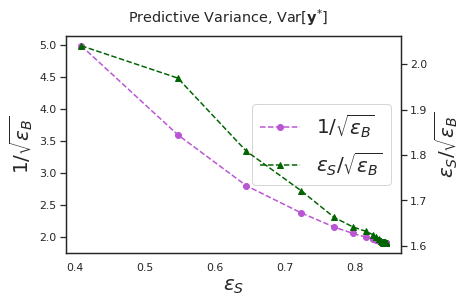

In [37]:
draw_curve(y_true, y_pred, predictive_variance, r'Predictive Variance, Var$[\mathbf{y}^{*}]$')

2.0679182942253007

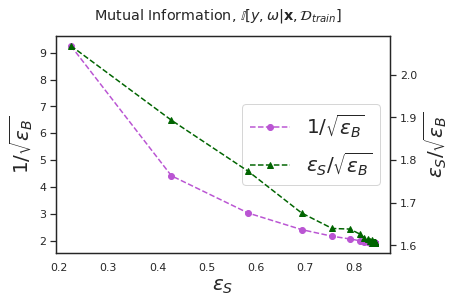

In [38]:
draw_curve(y_true, y_pred, mutual_information,
           r'Mutual Information, $ \mathbb{I}[y,\omega|\mathbf{x},\mathcal{D}_{train}]$')

1.7972152045381593

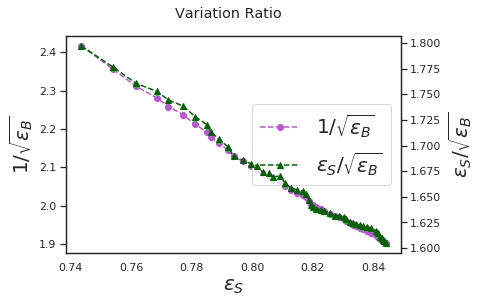

In [39]:
draw_curve(y_true, y_pred, variation_ratio, 'Variation Ratio')

2.042733946497605

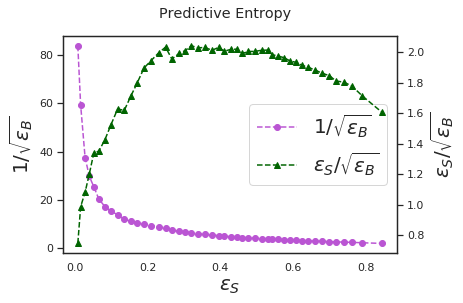

In [40]:
draw_curve(y_true, y_pred, predictive_entropy, 'Predictive Entropy')